# MNIST Dataset: Error Detection

In [1]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn import decomposition, svm
from sklearn import metrics

# choose GPUs
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())




#custom libraries
#base_dir = '/Users/cyrilwendl/Documents/EPFL'
base_dir = '/raid/home/cwendl'  # for guanabana
import sys
sys.path.append(base_dir + '/SIE-Master/Zurich') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package

from density_forest.density_forest import *
from density_forest.helpers import *
from density_forest.plots import *
from baselines.helpers import *
from helpers.helpers import *
from helpers.cross_validator import ParameterSearch
from helpers.plots import *
from parametric_tSNE.utils import *

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9329107011865716987
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10921197568
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 12039454419660705313
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1"
]
Instructions for updating:
Use the retry module or similar alternatives.


# Data Import 
Import the data, delete all data in the training set of class 7


In [2]:
# adapted from Source: https://github.com/keras-team/keras/tree/master/examples

# the data, shuffled and split between train and test sets
(x_train, y_train_label), (x_test, y_test_label) = mnist.load_data()

In [3]:
batch_size = 128
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.np_utils.to_categorical(y_train_label, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test_label, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = False
if model_train:
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    model.save('mnist_models/mnist-weights.h5')
else :
    model = load_model('mnist_models/mnist-weights.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

#### Make some predictions

In [5]:
y_pred_tr = model.predict(x_train)
y_pred_label_tr = get_y_pred_labels(y_pred_tr, background=False)

y_pred_te = model.predict(x_test)
y_pred_label_te = get_y_pred_labels(y_pred_te, background=False)

In [6]:
c = get_acc_net_max_margin(y_pred_te)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

pred_acc_high = .95 # 95 % is considered a very high confidence

pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 99.06 %
Std accuracy: 7.08 %
97.47% of all predictions made with an accuracy higher than 0.95%


# Network
MSR, Margin, Entropy

In [7]:
# metrics
y_true = (y_pred_label_te != y_test_label)*1

# msr
y_scores = 1-get_acc_net_msr(y_pred_te)
# PR
precision_msr, recall_msr, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_msr = metrics.average_precision_score(y_true, y_scores)
# ROC
auroc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = 1-get_acc_net_max_margin(y_pred_te)
# PR
precision_margin, recall_margin, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_margin = metrics.average_precision_score(y_true, y_scores)
# ROC
auroc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = 1-get_acc_net_entropy(y_pred_te)
# PR
precision_entropy, recall_entropy, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_entropy = metrics.average_precision_score(y_true, y_scores)
# ROC
auroc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)

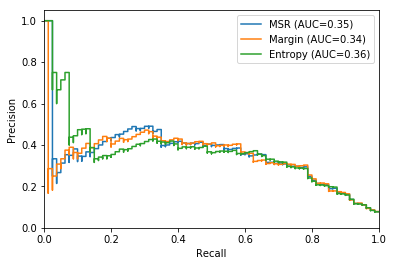

In [8]:
# plot
plt.step(recall_msr, precision_msr, where='post')
plt.step(recall_margin,precision_margin, where='post')
plt.step(recall_entropy, precision_entropy, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('MSR (AUC=%.2f)' % pr_auc_msr),
            str.format('Margin (AUC=%.2f)' % pr_auc_margin),
            str.format('Entropy (AUC=%.2f)' % pr_auc_entropy)])

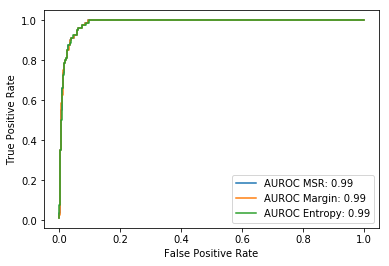

In [9]:
# ROC
plt.plot(fpr_msr,tpr_msr)
plt.plot(fpr_margin,tpr_margin)
plt.plot(fpr_entropy,tpr_entropy)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([str.format('AUROC MSR: %.2f') % auroc_msr,
            str.format('AUROC Margin: %.2f') % auroc_margin,
            str.format('AUROC Entropy: %.2f') % auroc_entropy
           ])

# Dropout

In [10]:
y_preds = predict_with_dropouts_batch(model, x_test, 
                                      batch_size=100, n_iter=20)

100%|██████████| 100/100 [00:10<00:00,  9.51it/s]


In [11]:
y_pred = np.mean(y_preds, axis=0)
probas = np.mean(np.std(y_preds, -1),0)

PR AUC: 0.31, AUROC: 0.98


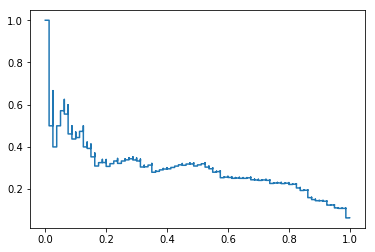

In [12]:
# precision-recall curve
y_scores = -probas
precision_dropout, recall_dropout, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_dropout = metrics.average_precision_score(y_true, y_scores)
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, y_scores)
auroc_dropout = metrics.roc_auc_score(y_true, y_scores)

plt.step(recall_dropout,precision_dropout)
print("PR AUC: %.2f, AUROC: %.2f"%(pr_auc_dropout, auroc_dropout))

## Get Activations, PCA, t-SNE

In [13]:
y_pred_tr = model.predict(x_train)
y_pred_label_tr = get_y_pred_labels(y_pred_tr, background=False)

In [14]:
pred_f_tr = np.where(y_pred_label_tr != y_train_label)[0]
pred_t_tr = np.where(y_pred_label_tr == y_train_label)[0]

pred_f_te = np.where(y_pred_label_te != y_test_label)[0]
pred_t_te = np.where(y_pred_label_te == y_test_label)[0]

In [15]:
# get activations of last layer
n_points = 15000
act_train_all = get_activations_batch(model, -2, x_train, batch_size=1000)
act_train = act_train_all[pred_t_tr]
print(np.shape(act_train_all))

act_test = get_activations(model, -2, x_test)[0]
print(np.shape(act_test))

(60000, 128)
(10000, 128)


In [16]:
pts_per_class = 300
n_classes=10
dataset_subset_indices = get_balanced_subset_indices(y_test_label, np.arange(n_classes), pts_per_class)

In [17]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
# t-SNE visualization after PCA
#tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

In [18]:
# color scale and legend for t-sne plots
colors = plt.cm.rainbow(np.linspace(0,1,n_classes))[:,:3]
names = ['Class '+str(i) for i in range(10)]
classes_to_keep = np.unique(y_test_label)

# plot
tsne_y = y_test_label[np.concatenate(dataset_subset_indices)]

Variance explained by first 15 components: 0.84


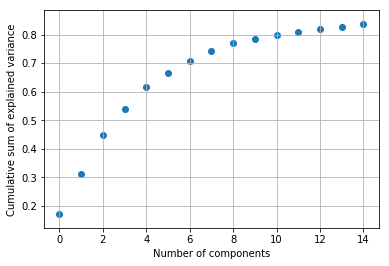

In [19]:
# PCA
n_components = 15
pca = decomposition.PCA(n_components=15)
pca.fit(act_train)

# plot
print("Variance explained by first %i components: %.2f" % (n_components, np.sum(pca.explained_variance_ratio_[:n_components])))
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.savefig("../Figures/DF/pca_components.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [20]:
X_train = pca.transform(act_train)
X_train_all = pca.transform(act_train_all)
X_test = pca.transform(act_test)

#### Visualize PCA

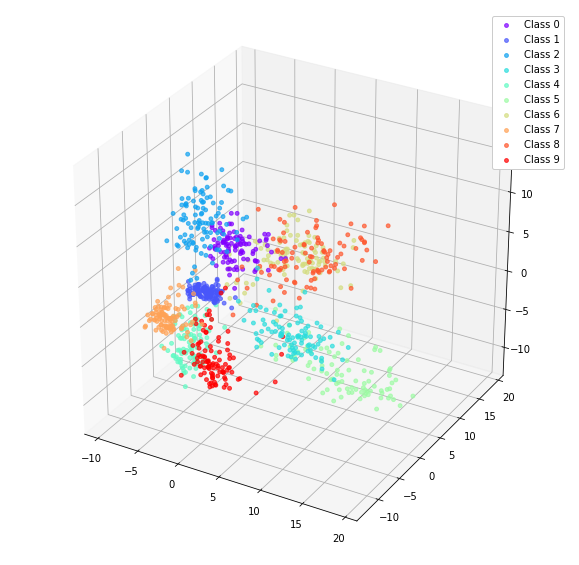

In [21]:
# test sample (with unseen class)
plot_pts_3d(X_test, y_test_label, classes_to_keep, names, colors, subsample_pct=.1)

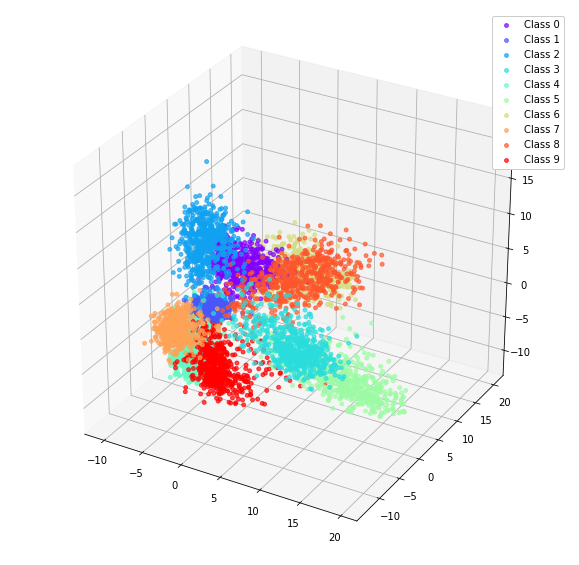

In [22]:
# training sample (without unseen class)
y_pca = y_train_label[pred_t_tr][:len(X_train)]
plot_pts_3d(X_train, y_pca, classes_to_keep, names, colors, subsample_pct=.1)

In [23]:
# t-SNE visualization after PCA
%time tsne_all = tsne.fit_transform(X_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 0.808s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.450361
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.501511
[t-SNE] Error after 300 iterations: 2.673749
CPU times: user 2min 50s, sys: 53.

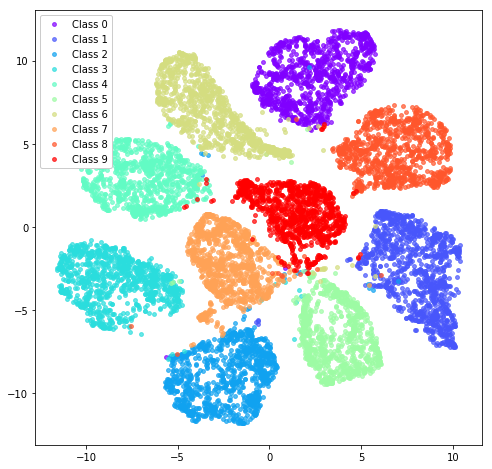

In [24]:
# plot
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_pts_2d(tsne_all, y_test_label, ax, classes_to_keep, names,
           colors, subsample_pct=1)

### GMM
GMM, calculate 

In [25]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

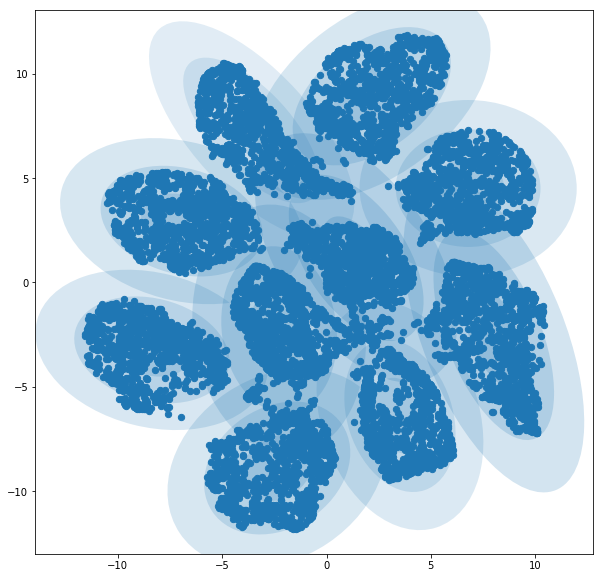

In [26]:
gmm = GaussianMixture(n_components=len(classes_to_keep), max_iter=10000)
fig, axes = plt.subplots(1,1,figsize=(10,10))
plot_gmm(gmm, tsne_all, label=False, ax=axes)

In [27]:
def scorer_roc_probas_gmm(gmm, X, y=None):
    """
    custom scorer for cross validation returning AUROC
    :param gmm: GMM classifier
    :param X: validation data
    :param y: optional gt data
    """
    probas = gmm.predict_proba(X)
    
    probas = -get_acc_net_entropy(probas)
    AUROC = metrics.roc_auc_score(y, probas)
    
    return AUROC

In [28]:
y_true_tr = (y_train_label != y_pred_label_tr)*1
tuned_parameters = [{'n_components': np.arange(1,15), 
                     'max_iter':[10000]}]

# do parameter search
ps = ParameterSearch(GaussianMixture, tuned_parameters, X_train, X_train_all, y_true_tr, scorer_roc_probas_gmm, n_iter=2,
                    verbosity=10, n_jobs=-1)
ps.fit()

[Parallel(n_jobs=40)]: Done   3 out of  14 | elapsed:   18.1s remaining:  1.1min
[Parallel(n_jobs=40)]: Done   5 out of  14 | elapsed:   24.4s remaining:   43.9s
[Parallel(n_jobs=40)]: Done   7 out of  14 | elapsed:   34.6s remaining:   34.6s
[Parallel(n_jobs=40)]: Done   9 out of  14 | elapsed:   49.7s remaining:   27.6s
[Parallel(n_jobs=40)]: Done  11 out of  14 | elapsed:   57.7s remaining:   15.7s
[Parallel(n_jobs=40)]: Done  14 out of  14 | elapsed:  1.3min finished


In [29]:
ps.best_params

{'max_iter': 10000, 'n_components': 10}

In [31]:
# fit best parameters
gmm = GaussianMixture(**(ps.best_params))
gmm.fit(X_train)

# predict
probas = gmm.predict_proba(X_test)
probas = get_acc_net_entropy(probas)

In [34]:
# Metrics
# PR
precision_gmm, recall_gmm, thresholds = metrics.precision_recall_curve(y_true, -probas)
pr_auc_gmm = metrics.auc(recall_gmm, precision_gmm)
# ROC
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, -probas)
auroc_gmm = metrics.roc_auc_score(y_true, -probas)

print("PR AUC: %.2f, AUROC: %.2f"%(pr_auc_gmm, auroc_gmm))

## Novelty Detection on Activations:
- One-class SVM
- Isolation Forest

### One-class SVM

In [36]:
def scorer_roc_probas_svm(svm, X, y=None):
    """
    custom scorer for cross validation returning AUROC
    :param svm: svm classifier
    :param X: validation data
    :param y: optional gt data
    """
    probas = -svm.decision_function(X)
    
    AUROC = metrics.roc_auc_score(y, probas)
    
    return AUROC

In [ ]:
svm.OneClassSVM()

In [37]:
y_true_tr = (y_train_label != y_pred_label_tr)*1
tuned_parameters=[{'kernel':['rbf'],
                   'nu':[.04, .2, .5], 
                   'max_iter':[10000]
                   
                   }]
# do parameter search
ps = ParameterSearch(svm.OneClassSVM, tuned_parameters, draw_subsamples(X_train,.2), X_train_all, y_true_tr, scorer_roc_probas_svm, n_iter=2,
                    verbosity=10, n_jobs=-1)
ps.fit()

[Parallel(n_jobs=40)]: Done   4 out of  53 | elapsed:    5.6s remaining:  1.1min
[Parallel(n_jobs=40)]: Done  10 out of  53 | elapsed:    9.4s remaining:   40.3s
[Parallel(n_jobs=40)]: Done  16 out of  53 | elapsed:   10.9s remaining:   25.3s
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=40)]: Done  22 out of  53 | elapsed:   25.1s remaining:   35.3s
[Parallel(n_jobs=40)]: Done  28 out of  53 | elapsed:   28.4s remaining:   25.3s
[Parallel(n_jobs=40)]: Done  34 out of  53 | elapsed:   35.1s remaining:   19.6s
[Parallel(n_

In [38]:
ps.best_params

{'degree': 7, 'kernel': 'poly', 'max_iter': 50000, 'nu': 0.3}

In [118]:
clf_svm = svm.OneClassSVM(degree=7, kernel='poly', nu=.3, verbose=True)

In [119]:
clf_svm.fit(X_train)

[LibSVM]

OneClassSVM(cache_size=200, coef0=0.0, degree=7, gamma='auto', kernel='poly',
      max_iter=-1, nu=0.3, random_state=None, shrinking=True, tol=0.001,
      verbose=True)

In [120]:
probas = clf_svm.decision_function(X_test)
probas -= np.min(probas)
probas /= np.max(probas)

In [121]:
#predict
probas = clf_svm.predict(X_test)

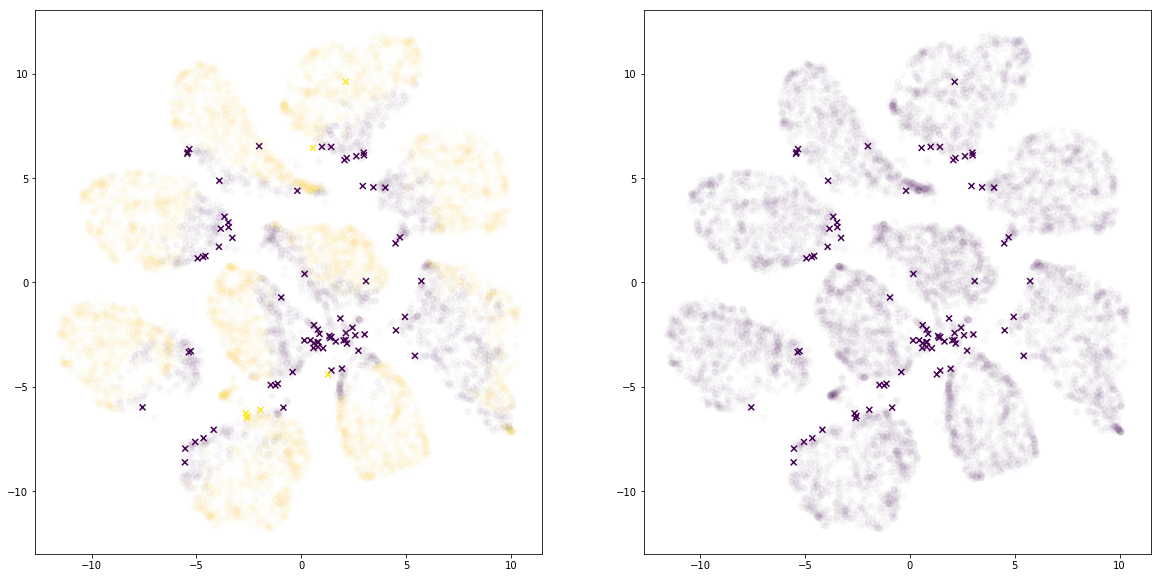

In [122]:
# plot correctly predicted points (x marker)
# plot correctly predicted points (o marker)
fig, axes = plt.subplots(1,2,figsize=(20,10)) 
axes[0].scatter(tsne_all[:,0][pred_t_te],tsne_all[:,1][pred_t_te], c=probas[pred_t_te], alpha=.02) # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_t_te],tsne_all[:,1][pred_t_te], c=(probas<np.sort(probas)[300])[pred_t_te], alpha=.02)  # 300 least certain points in yellow

# plot correctly predicted points (x marker)
# plot correctly predicted points (o marker)
axes[0].scatter(tsne_all[:,0][pred_f_te],tsne_all[:,1][pred_f_te],c=probas[pred_f_te], marker='x') # certainty for each point
axes[1].scatter(tsne_all[:,0][pred_f_te],tsne_all[:,1][pred_f_te],c=(probas<np.sort(probas)[300])[pred_f_te], marker='x')  # 300 least certain points in yellow

In [123]:
# Metrics
# PR
precision_svm, recall_svm, thresholds = metrics.precision_recall_curve(y_true, -probas)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)
# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, -probas)
auroc_svm = metrics.roc_auc_score(y_true, -probas)

print("PR AUC: %.2f, AUROC: %.2f"%(pr_auc_svm, auroc_svm))

PR AUC: 0.47, AUROC: 0.81


# Density Forest

In [52]:
class DensityForest:
    """
    Density Forest class
    """
    def __init__(self, max_depth, min_subset, n_trees, n_max_dim=0, n_jobs=-1, verbose=1,
                 fact_improvement=.9, funct=create_density_tree, n_clusters=None, thresh_traverse=0, method='normal',
                 subsample_pct = .1, standardize=False):
        """
        :param max_depth: maximum depth for each tree
        :param min_subset: minimum percentage of data which should be contained in each leaf node
        :param n_trees: number of trees to create
        :param subsample_pct: percentage of original dataset on which to create trees
        :param n_max_dim: maximum number of dimensions within which to search for best split
        :param fact_improvement: minimum improvement factor needed to continue splitting tree
        :param n_jobs: number of processors to use for parallel processing. If -1, all processors are used
        :param verbose: verbosity level of parallel processing
        :param funct: function name for creation of density trees (create_density_tree or create_density_tree_v1)
        :param n_clusters: number of clusters, only relevant if function create_density_tree_v1 is set
        :param thresh_traverse: threshold of min. pct of points per leaf node to consider a tree
        :param method: 'normal' for probability estimation according to Gaussianity, 'euclid' for distance to mean
        :return root_nodes: array of root nodes of each tree in Density Forest
        """
        self.max_depth = max_depth
        self.min_subset = min_subset
        self.n_trees = n_trees
        self.n_max_dim = n_max_dim
        if n_jobs == -1:
            self.n_jobs = multiprocessing.cpu_count()
        else:
            self.n_jobs = np.min([n_jobs, multiprocessing.cpu_count()])
        self.verbose = verbose
        self.fact_improvement = fact_improvement
        self.funct = funct
        self.n_clusters = n_clusters
        self.thresh_traverse = thresh_traverse
        self.method = method
        self.standardize = standardize
        self.root_nodes = None
        self.subsample_pct = subsample_pct

    def fit(self, dataset):
        """
        Create density forest on a dataset
        :param dataset: dataset on which to create density forest
        :param subsample_pct: subsample percentage of data on which to fit df
        """
        if self.verbose:
            print("Number of points on which to train each tree: %i" % int(len(dataset) * self.subsample_pct))
            print("Minimum number of points in each leaf: %i" % int(
                len(dataset) * self.subsample_pct * self.min_subset))

        if self.funct == create_density_tree:
            root_nodes = Parallel(n_jobs=self.n_jobs, verbose=self.verbose)(
                delayed(create_density_tree)(
                    draw_subsamples(dataset, subsample_pct=self.subsample_pct, replace=True), self.max_depth,
                    min_subset=self.min_subset, n_max_dim=self.n_max_dim, fact_improvement=self.fact_improvement)
                for _ in range(self.n_trees))
        else:
            root_nodes = Parallel(n_jobs=self.n_jobs, verbose=self.verbose)(
                delayed(create_density_tree_v1)(
                    draw_subsamples(dataset, subsample_pct=self.subsample_pct, replace=True), self.n_clusters,
                    n_max_dim=self.n_max_dim)
                for _ in range(self.n_trees))

        root_nodes = np.asarray(root_nodes)
        root_nodes = root_nodes[[root_node is not None for root_node in root_nodes]]  # only keep not-None root nodes

        if self.verbose:
            print("Number of created root nodes: %i" % len(root_nodes))
            x = [get_clusters(root_nodes[i], [], []) for i in range(len(root_nodes))]
            lens = [len(x[i][1]) for i in range(len(x))]
            print("Mean number of clusters created per tree: %i" % int(np.mean(lens)))

        self.root_nodes = root_nodes

    def predict(self, dataset, batch_size=-1):
        """
        traverse Density Forest (DF) and get mean probability for point to belong to the leaf clusters of each tree
        :param dataset: dataset for which to traverse density forest
        :param batch_size: optional argument for batch traversal
        """

        # set up variables
        if batch_size > 0:
            return self.predict_batch(dataset, batch_size)
        else:
            pairs_proba = np.empty((len(dataset), len(self.root_nodes)), float)  # indexes of data points

            # get all clusters for all points in all trees
            for d_idx, d in enumerate(dataset):
                # traverse all trees
                for t_idx, tree in enumerate(self.root_nodes):
                    d_mean, d_pct, d_pdf_mean, d_cov_det, d_cov_inv = descend_density_tree(d, tree)
                    if d_pct > self.thresh_traverse:
                        if self.method == 'normal':
                            pairs_proba[d_idx, t_idx] = d_pct * my_normal(d, d_mean, d_cov_det, d_cov_inv)
                            if self.standardize:
                                pairs_proba[d_idx, t_idx] /= d_pdf_mean  # standardize by max. probability
                        else:
                            pairs_proba[d_idx, t_idx] = euclidean(d_mean, d)
                            if self.standardize:
                                pairs_proba[d_idx, t_idx] /= d_pdf_mean  # standardize by max. probability
                    else:
                        pairs_proba[d_idx, t_idx] = np.nan

            return np.nanmean(pairs_proba, axis=-1)

    def predict_batch(self, dataset, batch_size):
        """
        Traverse a Density forest in batches and in parallel
        :param batch_size: batch size of dataset for which to do df_traverse at a time
        :param dataset: dataset for which to traverse density forest
        :return: Gaussian probabilities for dataset
        """
        steps = np.linspace(0, len(dataset), int(len(dataset) / batch_size), dtype='int')
        print("Total steps: %i" % len(steps))

        print("Number of jobs: %i " % self.n_jobs)

        probas = Parallel(n_jobs=self.n_jobs, verbose=self.verbose)(
            delayed(self.predict)(dataset[steps[i]:steps[i + 1], :], self.root_nodes,
                                  thresh=self.thresh_traverse, method=self.method, standardize=self.standardize)
            for i in range(len(steps) - 1))

        probas = np.concatenate(probas)
        if self.method == 'euclid':
            probas = 1 - probas

        return probas


In [54]:
def scorer_roc_probas_df(clf_df, X, y=None):
    """
    custom scorer for cross validation returning AUROC
    :param svm: svm classifier
    :param X: validation data
    :param y: optional gt data
    """
    probas = -clf_df.predict(X)
    AUROC = metrics.roc_auc_score(y, probas)
    return AUROC

In [127]:
tuned_parameters=[{'max_depth':[2],
                  'min_subset':[.1],
                  'n_trees':[20],
                  'n_max_dim':[5],
                  'n_jobs':[-1],
                  'subsample_pct':[.01],
                  'fact_improvement':[.7]}]
# TODO add fact_improvement, other parameters

# do parameter search
ps = ParameterSearch(DensityForest, tuned_parameters, X_train, X_train_all, y_true_tr, scorer_roc_probas_df, n_iter=2,
                    verbosity=0, n_jobs=1)

ps.fit()

In [126]:
ps.best_params

{'fact_improvement': 0.7,
 'max_depth': 2,
 'min_subset': 0.1,
 'n_jobs': -1,
 'n_max_dim': 5,
 'n_trees': 2,
 'subsample_pct': 0.1}

In [130]:
#clf_df = DensityForest(**(ps.best_params))
clf_df = DensityForest(max_depth=2, min_subset=.1, n_trees=20, n_max_dim=5, 
                       n_jobs=-1, subsample_pct=.01, fact_improvement=.7)
clf_df.fit(X_train)

Number of points on which to train each tree: 599
Minimum number of points in each leaf: 59


[Parallel(n_jobs=40)]: Done   4 out of  20 | elapsed:   14.5s remaining:   57.9s


Number of created root nodes: 20
Mean number of clusters created per tree: 7


[Parallel(n_jobs=40)]: Done  20 out of  20 | elapsed:   16.4s finished


In [131]:
probas = clf_df.predict(X_test)

In [136]:
probas[probas==np.infty] = 10^10

0.030939774604894738

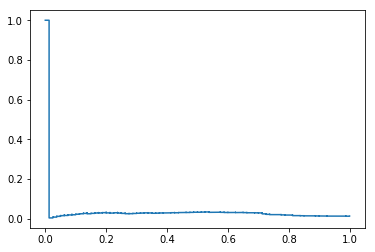

In [137]:
# precision-recall curve
y_scores = -probas
# PR
precision_df, recall_df, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_df = metrics.auc(recall_df, precision_df)
# ROC
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
auroc_df = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_df, precision_df)
metrics.auc(recall_df, precision_df)

## Plot Results

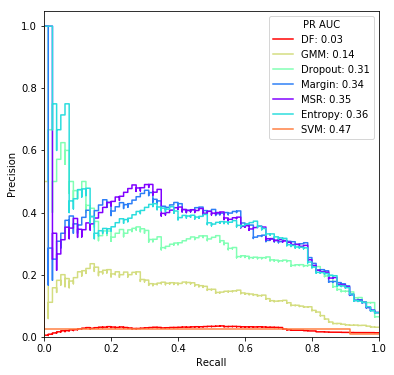

In [138]:
# Precision-Recall Curve
# order according to increasing score
scores_pr = [pr_auc_msr, pr_auc_margin, pr_auc_entropy, pr_auc_dropout, pr_auc_gmm, pr_auc_svm, pr_auc_df]
recalls = [recall_msr, recall_margin, recall_entropy, recall_dropout, recall_gmm, recall_svm, recall_df]
precisions = [precision_msr, precision_margin, precision_entropy, precision_dropout, precision_gmm, precision_svm, precision_df]
names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'SVM', 'DF'])
scores_order = np.argsort(scores_pr)
colors_lines = plt.cm.rainbow(np.linspace(0,1,len(scores_pr)))[:,:3]

# plot
plt.figure(figsize=(6,6))
for i in scores_order:
    plt.step(recalls[i], precisions[i], where='post', c=colors_lines[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_pr[i]) for i in scores_order], title="PR AUC")
plt.savefig("../Figures/MNIST/PR_ED.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

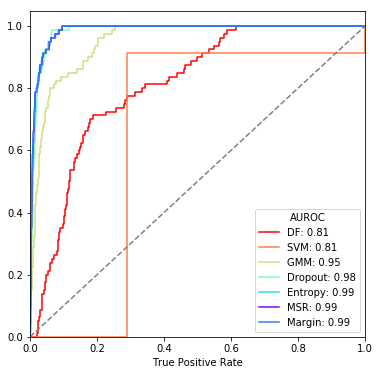

In [139]:
# ROC
# order according to increasing score
scores_auc = [auroc_msr, auroc_margin, auroc_entropy, auroc_dropout, auroc_gmm, auroc_svm, auroc_df]
fprs = [fpr_msr, fpr_margin, fpr_entropy, fpr_dropout, fpr_gmm, fpr_svm, fpr_df]
tprs = [tpr_msr, tpr_margin, tpr_entropy, tpr_dropout, tpr_gmm, tpr_svm, tpr_df]
names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'SVM', 'DF'])
scores_order = np.argsort(scores_auc)
colors_lines = plt.cm.rainbow(np.linspace(0,1,len(scores_auc)))[:,:3]

# plot
plt.figure(figsize=(6,6))
for i in scores_order:
    plt.step(fprs[i], tprs[i], where='post', c=colors_lines[i])

plt.plot([0,1],[0,1], '--', c='gray')
plt.xlabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_auc[i]) for i in scores_order], title="AUROC")
plt.savefig("../Figures/MNIST/ROC_ED.pdf", bbox_inches='tight', pad_inches=0)
plt.show()